In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, Matern
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import norm
import scipy
import odor_stat_calculations as osc

import matplotlib.pyplot as plt 

In [237]:
hws= pd.read_hdf('/home/gorilla/An/data/Sprints/HighRes/Windy/WindyStatsTime_std.h5')

In [2]:
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')


index = osc.get_index(df.odor,3)
whiff_initiation_points = [sub[0] for sub in index]
df['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
df.iloc[whiff_initiation_points, df.columns.get_loc('whiff_flag')] = 1

df_train = df[:22000]
df_test = df[22000:]

query = 'odor>2'
df_train = df_train.query(query)
df_train.reset_index(inplace=True, drop=True)
df_test = df_test.query(query)
df_test.reset_index(inplace=True, drop=True)

In [39]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


In [41]:

# Define your features and the binary target (whiff_flag)
X = df_train[['distance_along_streakline', 'nearest_from_streakline']].values
y = df_train['whiff_flag'].values  # Binary target (0 or 1)

# Scale the features
use_scaler = True  
if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    X_scaled = X

# Define the kernel for the Gaussian Process Classifier (GPC)
kernel = C(1.0, (1e-2, 1e2)) * (RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1)) + Matern(nu=1.5))

# Train the GPC model
gpc = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=3, random_state=42)
gpc.fit(X_scaled, y)

# Prepare the test data
X_test = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
X_test_scaled = scaler.transform(X_test)

# Make predictions with the trained GPC
# y_pred = gpc.predict(X_test_scaled)
y_pred_proba = gpc.predict_proba(X_test_scaled)[:, 1]
# # Evaluate the binary predictions
# print("Classification Report:\n", classification_report(df_test['whiff_flag'], y_pred))
# print("Confusion Matrix:\n", confusion_matrix(df_test['whiff_flag'], y_pred))

# Use a lower threshold (e.g., 0.3) to classify more positive cases
threshold = 0.3
y_pred_binary = (y_pred_proba >= threshold).astype(int)

# Evaluate the model again with the new threshold
print("Classification Report:\n", classification_report(df_test['whiff_flag'], y_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(df_test['whiff_flag'], y_pred_binary))


/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76       377
           1       0.35      0.46      0.40       121

    accuracy                           0.66       498
   macro avg       0.58      0.59      0.58       498
weighted avg       0.70      0.66      0.67       498

Confusion Matrix:
 [[273 104]
 [ 65  56]]


In [45]:
len(y_pred_binary)

498

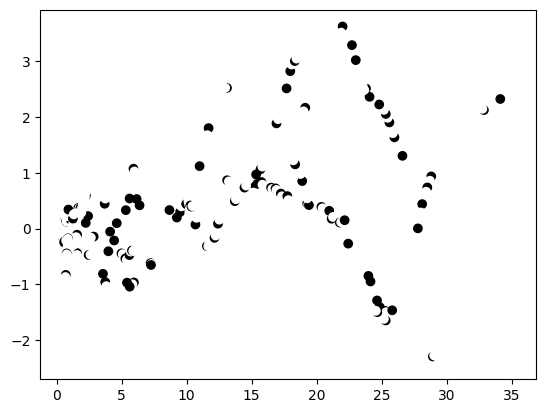

In [46]:
plt.scatter(df_test.distance_along_streakline,df_test.nearest_from_streakline, c=df_test.whiff_flag, cmap='bone_r')

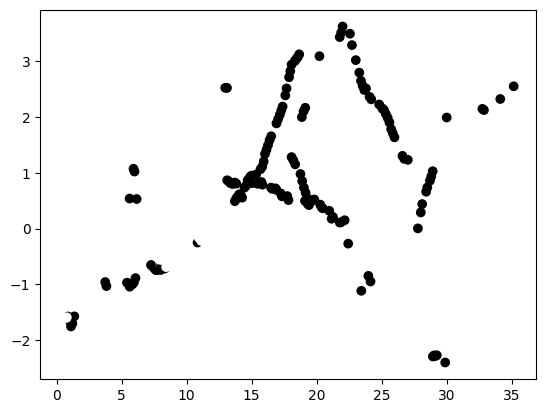

In [47]:
plt.scatter(df_test.distance_along_streakline,df_test.nearest_from_streakline, c=y_pred_binary, cmap='bone_r')

In [21]:
new_X_test = df_test[['distance_along_streakline', 'nearest_from_streakline']].values

if scaler is not None:
    new_X_test_scaled = scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

new_y_pred_mean, new_y_pred_std = gp.predict(new_X_test_scaled, return_std=True)

threshold = 0.5
new_y_pred_binary = (new_y_pred_mean >= threshold).astype(int)

df_test['whiff_initiation_pred'] = new_y_pred_binary

true_y_test = df_test['whiff_flag'].values

print("Classification Report:\n", classification_report(true_y_test, new_y_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(true_y_test, new_y_pred_binary))

# Print out


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       377
           1       0.20      0.01      0.02       121

    accuracy                           0.75       498
   macro avg       0.48      0.50      0.44       498
weighted avg       0.62      0.75      0.65       498

Confusion Matrix:
 [[373   4]
 [120   1]]


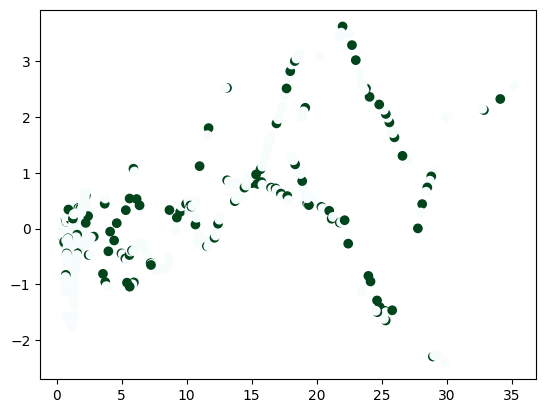

In [22]:
plt.scatter(df_test.distance_along_streakline,df_test.nearest_from_streakline, c=df_test.whiff_flag, cmap='BuGn')

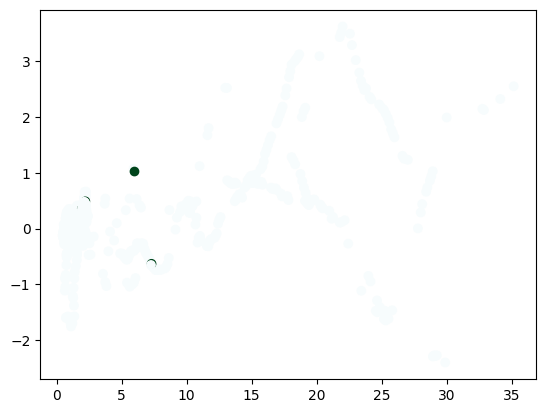

In [23]:
plt.scatter(df_test.distance_along_streakline,df_test.nearest_from_streakline, c=df_test.whiff_initiation_pred, cmap='BuGn')

In [220]:

# Load the data
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')
df_train = df[:22000]
df_test = df[22000:]

# Filter the training and test data
# query = 'odor>2'
# df_train = df_train.query(query)
# df_train.reset_index(inplace=True, drop=True)
# df_test = df_test.query(query)
# df_test.reset_index(inplace=True, drop=True)

# Function to fit an exponential distribution to the data below a threshold
def fit_exponential_distribution(far_data, threshold):
    non_saturated_data = far_data[far_data['odor'] < threshold]['odor']
    loc, scale = stats.expon.fit(non_saturated_data)
    return loc, scale

# Generate values above a threshold using an exponential distribution
def generate_values_above_threshold(loc, scale, threshold, size):
    cdf_threshold = stats.expon.cdf(threshold, loc=loc, scale=scale)
    uniform_values = np.random.uniform(cdf_threshold, 1, size)
    values_above_threshold = stats.expon.ppf(uniform_values, loc=loc, scale=scale)
    return values_above_threshold

# Replace saturated values in the data with estimated values from an exponential distribution
def estimate_values_with_exponential_distribution(df, threshold, loc, scale):
    saturated_indices = df[df['odor'] >= threshold].index
    estimated_values = generate_values_above_threshold(loc, scale, threshold, len(saturated_indices))
    df.loc[saturated_indices, 'odor'] = estimated_values
    return df

# Copy the train data
df_extracted = df_train.copy()

# Set thresholds
far_distance_threshold = 10
saturation_threshold = 10

# Fit exponential distribution to the training data for correction
far_data = df_extracted[df_extracted['distance_along_streakline'] > far_distance_threshold]
loc, scale = fit_exponential_distribution(far_data, saturation_threshold)

# Apply the correction to the training data
df_corrected = estimate_values_with_exponential_distribution(df_extracted.copy(), saturation_threshold, loc, scale)


whiff_threshold = 0.8  # Define a threshold for whiff initiation
df_corrected['whiff_initiation'] = (df_corrected['odor'] >= whiff_threshold).astype(int)

# Prepare features and binary target for training
X = df_corrected[['distance_along_streakline', 'nearest_from_streakline']].values
y = df_corrected['whiff_initiation'].values



In [221]:
print(df_corrected['whiff_initiation'].value_counts())

0    15511
1     6489
Name: whiff_initiation, dtype: int64


In [229]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

grid_size=80
# Step 2: Create a finer grid over the input feature space
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size),  # 200 points for smaller grid
                     np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size))  # 200 points for smaller grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Step 3: Scale the grid points
grid_points_scaled = scaler.transform(grid_points)

# Step 4: Predict the probabilities for each grid point using the trained model
grid_probabilities = rf.predict_proba(grid_points_scaled)[:, 1]

In [230]:
query = 'odor>2'
dftrain = df_train.query(query)
dftrain.reset_index(inplace=True, drop=True)

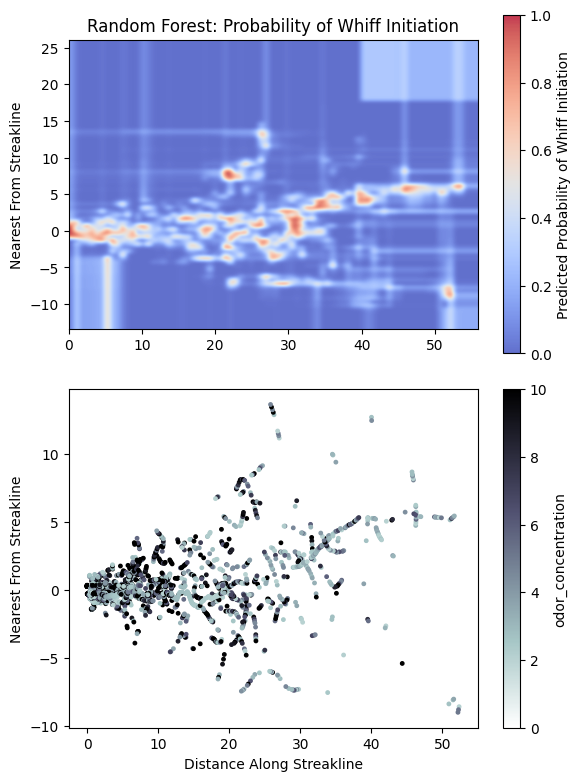

In [236]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))
# cax = ax.contourf(xx, yy, grid_probabilities.reshape(xx.shape), cmap='coolwarm', alpha=0.8,  vmin=0,vmax=1)
# cax = ax.imshow(grid_probabilities.reshape(xx.shape), origin='lower',
#                 extent=[X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()],
#                 cmap='coolwarm', alpha=0.8, vmin=0, vmax=1, interpolation='bilinear')  # interpolation='bilinear' smooths the heatmap

grid_probabilities_reshaped = grid_probabilities.reshape(xx.shape)

cax = ax[0].imshow(grid_probabilities_reshaped, origin='lower', extent=[X[:, 0].min(), X[:, 0].max(),
                                                                     X[:, 1].min(), X[:, 1].max()],
                cmap='coolwarm', alpha=0.8, vmin=0, vmax=1, interpolation='bicubic')  # Apply interpolation='bilinear'



plt.colorbar(cax, label='Predicted Probability of Whiff Initiation')
# ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm')

ax[0].set_title('Random Forest: Probability of Whiff Initiation')
# ax[0].set_xlabel('Distance Along Streakline')
ax[0].set_ylabel('Nearest From Streakline')

cax2 = ax[1].scatter(dftrain.distance_along_streakline, dftrain.nearest_from_streakline, 
                     c=dftrain.odor, cmap='bone_r', s=6, vmin=0, vmax=10)
plt.colorbar(cax2, label='odor_concentration')

# ax[1].set_title('Odor')
ax[1].set_xlabel('Distance Along Streakline')
ax[1].set_ylabel('Nearest From Streakline')

fig.tight_layout()

In [9]:
# Prepare the test data
new_test_df = df_test.copy()
new_test_df.reset_index(inplace=True, drop=True)

# Apply the correction to the test data
new_test_corrected = estimate_values_with_exponential_distribution(new_test_df.copy(), saturation_threshold, loc, scale)

# Prepare the test features
new_X_test = new_test_corrected[['distance_along_streakline', 'nearest_from_streakline']].values
new_X_test_scaled = scaler.transform(new_X_test)

# Make predictions for the test set
whiff_probabilities = gpc.predict_proba(new_X_test_scaled)  # Get the probabilities for both classes
whiff_predictions = gpc.predict(new_X_test_scaled)  # Get binary predictions (0 or 1)

# Add predictions to the test dataframe
new_test_df['whiff_initiation'] = (new_test_df['odor'] >= whiff_threshold).astype(int)
new_test_df['whiff_predictions'] = whiff_predictions

# Evaluate the model using accuracy, confusion matrix, and classification report
print("Accuracy:", accuracy_score(new_test_df['whiff_initiation'], whiff_predictions))
print("Confusion Matrix:\n", confusion_matrix(new_test_df['whiff_initiation'], whiff_predictions))
print("Classification Report:\n", classification_report(new_test_df['whiff_initiation'], whiff_predictions))

Accuracy: 0.5602409638554217
Confusion Matrix:
 [[ 22 193]
 [ 26 257]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.10      0.17       215
           1       0.57      0.91      0.70       283

    accuracy                           0.56       498
   macro avg       0.51      0.51      0.43       498
weighted avg       0.52      0.56      0.47       498



In [36]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# Prepare your training data
X_train = df_train[['distance_along_streakline', 'nearest_from_streakline']].values
y_train = df_train['whiff_flag'].values

# Scale the input data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define the kernel (RBF kernel for spatial classification)
# Define the combined kernel
kernel = C(1.0, (1e-2, 1e2)) * (RBF(length_scale=1.0))


# Create the Gaussian Process Classifier
gpc = GaussianProcessClassifier(kernel=kernel)

# Fit the model
gpc.fit(X_train_scaled, y_train)

# Prepare test data
X_test = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
X_test_scaled = scaler.transform(X_test)
y_test = df_test['whiff_flag'].values

# Make predictions on test data
y_pred = gpc.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Predict probabilities for better insight into uncertainty
y_pred_proba = gpc.predict_proba(X_test_scaled)[:, 1]


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.86       377
           1       0.45      0.04      0.08       121

    accuracy                           0.76       498
   macro avg       0.61      0.51      0.47       498
weighted avg       0.69      0.76      0.67       498

Confusion Matrix:
 [[371   6]
 [116   5]]


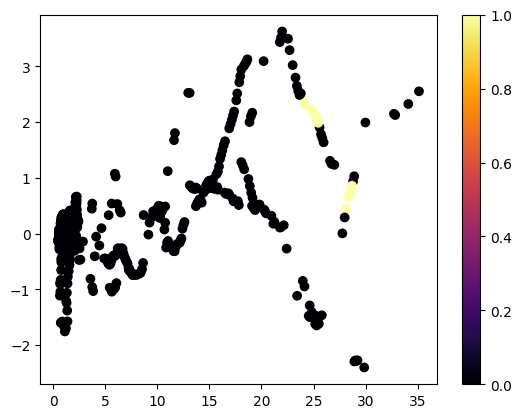

In [37]:
plt.scatter(df_test.distance_along_streakline,df_test.nearest_from_streakline,c=y_pred,cmap='inferno')
plt.colorbar()

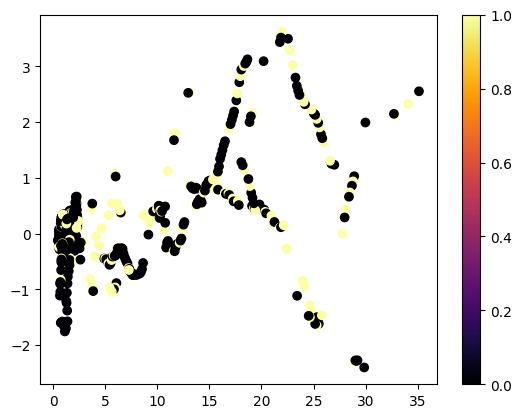

In [38]:
plt.scatter(df_test.distance_along_streakline,df_test.nearest_from_streakline,c=y_test,cmap='inferno')
plt.colorbar()